In [1]:
import stftAnSyn as stft
import dftAnSyn as dft
import SinesAnSyn as sines
import harmonicAnSyn as harms
import Utilities as U

In [2]:
import numpy as np
from scipy.signal import get_window, blackmanharris
from scipy.signal import chirp, triang
from scipy.fftpack import ifft
import scipy.io.wavfile as wavfile
import os, sys
import matplotlib.pyplot as plt

In [6]:
def normalize_signal(signal):
    signal = np.double(signal)
    return (signal - signal.mean()) / ((np.abs(signal)).max() + 0.0000000001)

In [7]:
sr = 44100
f0 = 150 # Hz
f1 = 8500 # Hz
t1 = 2 # seconds
t = np.linspace(0,t1,int(t1*sr))
chirpSig = chirp(t, f0, t1, f1)
wavfile.write("chirp.wav", sr, np.int16(chirpSig*2**14))

Text(0, 0.5, 'sample value')

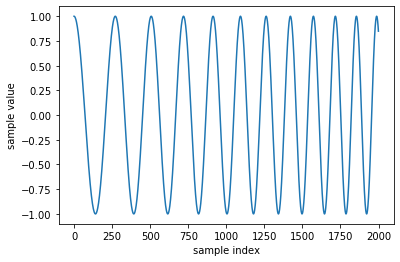

In [8]:
plt.plot(chirpSig[0:2000])
plt.xlabel('sample index')
plt.ylabel('sample value')

In [9]:
(fs, x) = wavfile.read('mono_noisy_hello.wav')

Text(0, 0.5, 'sample value')

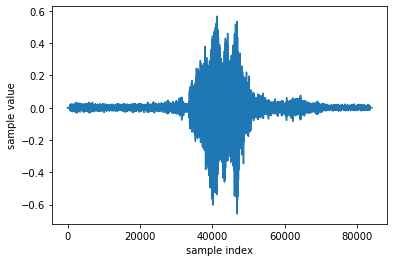

In [10]:
plt.plot(x[0:88000])
plt.xlabel('sample index')
plt.ylabel('sample value')

In [11]:
N = 512
M = 256
H = 128
w = get_window("blackman",M)
mX, phX = stft.stftAnal(x, w, N, H)
y = stft.stftSynth(mX, phX, w.size,H)
wavfile.write("newHello.wav", fs, y)

In [12]:
(fs, x) = wavfile.read('sine440.wav')

In [13]:
M = 512
N = 2048
tresh = -20
win = get_window('hamming',M)
x1 = x[int(.8*fs):int(.8*fs)+M]

In [15]:
(mX, pX) = dft.dftAnal(x1, win, N)
peaks = U.peakDetection(mX, tresh)
pMag = mX[peaks]

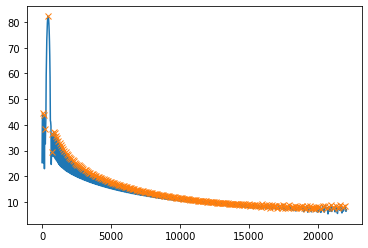

In [16]:
freqaxe = fs * np.arange(N/2+1)/float(N)
plt.plot(freqaxe, mX)
plt.plot(fs * peaks/ float(N), pMag, marker='x', linestyle='')
plt.show()

In [17]:
pLoc, pMag, pPh = U.peak_parabolicInterp(mX, pX, peaks)

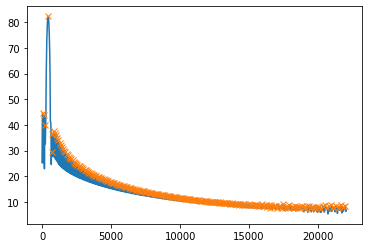

In [18]:
freqaxe = fs * np.arange(N/2+1)/float(N)
plt.plot(freqaxe, mX)
plt.plot(fs * pLoc/ float(N), pMag, marker='x', linestyle='')
plt.show()

/Users/leofltt/Desktop/Audio-Analysis-Experiments/DSP/Utilities.py:56: RuntimeWarning: invalid value encountered in true_divide
  y = np.sin(N * x/2) / np.sin(x/2)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


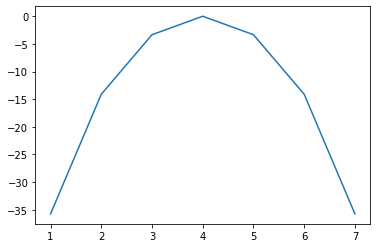

In [19]:
bins = np.array([-4,-3,-2,-1,0,1,2,3])
X = U.genBhLobe(bins)
plt.plot(20 * np.log10(X))

In [20]:
sf = 44100
N = 512
peakFreq = np.array([4000])
peakMag = np.array([0])
peakPhase = np.array([0])

In [21]:
Y = U.genSinesSpectrum(peakFreq, peakMag, peakPhase, N, sf)

In [22]:
absY = abs(Y[:int(N/2)])
absY[absY < np.finfo(float).eps] = np.finfo(float).eps

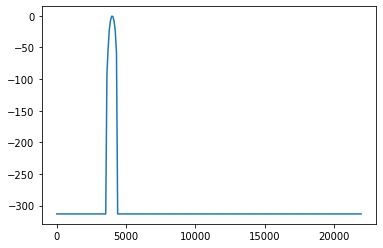

In [23]:
freqAxe = fs * np.arange(N/2)/float(N)
plt.plot(freqAxe, 20 * np.log10(absY))
plt.show()

In [24]:
hN = int(N/2)
y = np.real(ifft(Y))
synthwin = np.zeros(N)
ow = triang(N/2)
synthwin[hN-H:hN+H] = ow
bh = blackmanharris(N)
bh = bh/sum(bh)
synthwin[hN-H:hN+H] = synthwin[hN-H:hN+H] / bh[hN-H:hN+H] 

In [25]:
yw = np.zeros(N)
yw[:hN-1] = y[hN+1:]
yw[hN-1:] = y[:hN+1]
yw *= synthwin

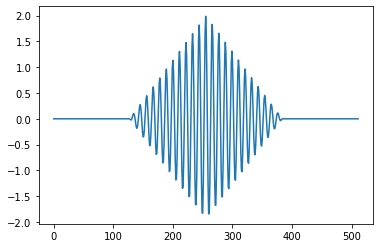

In [26]:
plt.plot(yw)
plt.show()

In [28]:
(fs, x) = wavfile.read('oboe-A4.wav')
N = 512
hN = int(N/2)
H = int(N/4)
M = 511
tresh = -70
win = get_window('hamming',M)
x1 = x[int(0.8*fs):int(0.8*fs)+M]
(mX, pX) = dft.dftAnal(x1,win,N)
peaks = U.peakDetection(mX, tresh)
(peakC, peakMag, peakPh) = U.peak_parabolicInterp(mX,pX,peaks)
peakFreq = fs*peaks/float(N)
Y = U.genSinesSpectrum(peakFreq, peakMag, peakPh, N, fs)
y = np.real(ifft(Y))

In [29]:
synthesisWindow = np.zeros(N)
ow = triang(N/2)
synthesisWindow[hN-H:hN+H] = ow
bh = blackmanharris(N)
bh = bh / sum(bh)
synthesisWindow[hN-H:hN+H] = synthesisWindow[hN-H:hN+H] / bh[hN-H:hN+H]


In [30]:
ywin = np.zeros(N)
ywin[:hN-1] = y[hN+1:]
ywin[hN-1:] = y[:hN+1]
ywin *= synthesisWindow

<function matplotlib.pyplot.show(*args, **kw)>

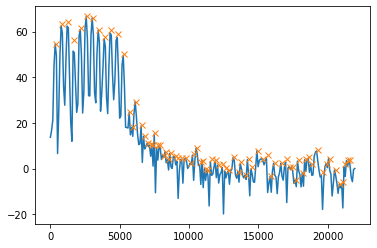

In [31]:
freqAxe = fs * np.arange(N/2)/float(N)
plt.plot(freqAxe, mX[1:])
plt.plot(fs*peaks / N, peakMag, marker='x',linestyle='')
plt.show

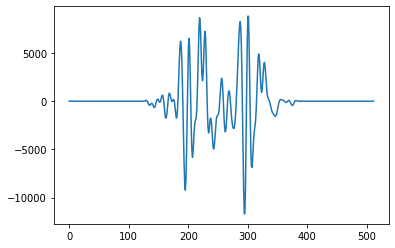

In [32]:
plt.plot(ywin)
#plt.plot(y)

In [47]:
(fs, x) = wavfile.read('VocalChop.wav')
N = 2048
M = 2000
tresh = -80
H = 128
win = get_window('hamming',M)
minDur = 0.02
maxSines = 100
freqSlope = 0.001
freqDevOff = 10

tfreq, tmag, tphase = sines.sineModelAnal(x, fs, win, N, H, tresh, maxSines, minDur, freqDevOff, freqSlope)

No = 512
out = sines.sineModelSynth(tfreq,tmag,tphase,No,H,fs)
out = np.int16(out)
wavfile.write("trackedSines.wav", fs, out)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


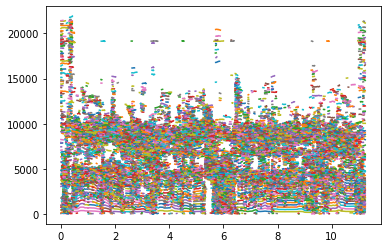

In [35]:
nframes = int(tfreq[:,0].size)
fT = H * np.arange(nframes)/float(fs)
tfreq[tfreq<=0] = np.nan
plt.plot(fT, tfreq)
plt.show()

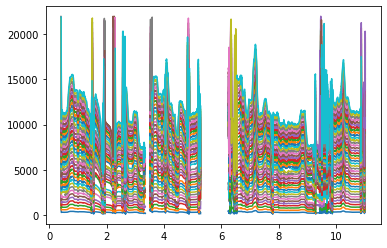

In [5]:
(fs, x) = wavfile.read('VocalChop.wav')
N = 2048
M = 1201
tresh = -90
nH = 40
win = get_window('blackman',M)
minSineDur = 0.3
minf0 = 100
maxf0 = 800
f0e = 5
harmSlope = 0.01

Ns = 512
H = 128

hfreq, hmag, hphase = harms.harmonicModelAnal(x, fs, win, N, H, tresh, nH, minf0, maxf0, f0e, harmSlope, minSineDur)

numFrames = int(hfreq[:,0].size)
fTime = H*np.arange(numFrames)/float(fs)
hfreq[hfreq<=0] = np.nan

plt.plot(fTime, hfreq)
plt.show()

out = harms.harmonicModel(x, fs, win, N, tresh, nH, minf0, maxf0, f0e)
out = np.int16(out)
wavfile.write("trackedHarmonics.wav", fs, out)
